In [ ]:
!git lfs install

Git LFS initialized.


In [ ]:
!git clone https://huggingface.co/spaces/job2023/florence-sam-comvision

Cloning into 'florence-sam'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91 (from 1)
Unpacking objects: 100% (91/91), 17.10 KiB | 603.00 KiB/s, done.
Filtering content: 100% (7/7), 1.46 GiB | 54.98 MiB/s, done.


In [ ]:
cd florence-sam

/content/florence-sam


In [ ]:
!pwd

/content/florence-sam


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00


In [ ]:
pip install transformers==4.49.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


Processing mode: caption + grounding + image masks
Image path: /content/florence-sam/mango.jpeg
Text input: None


SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


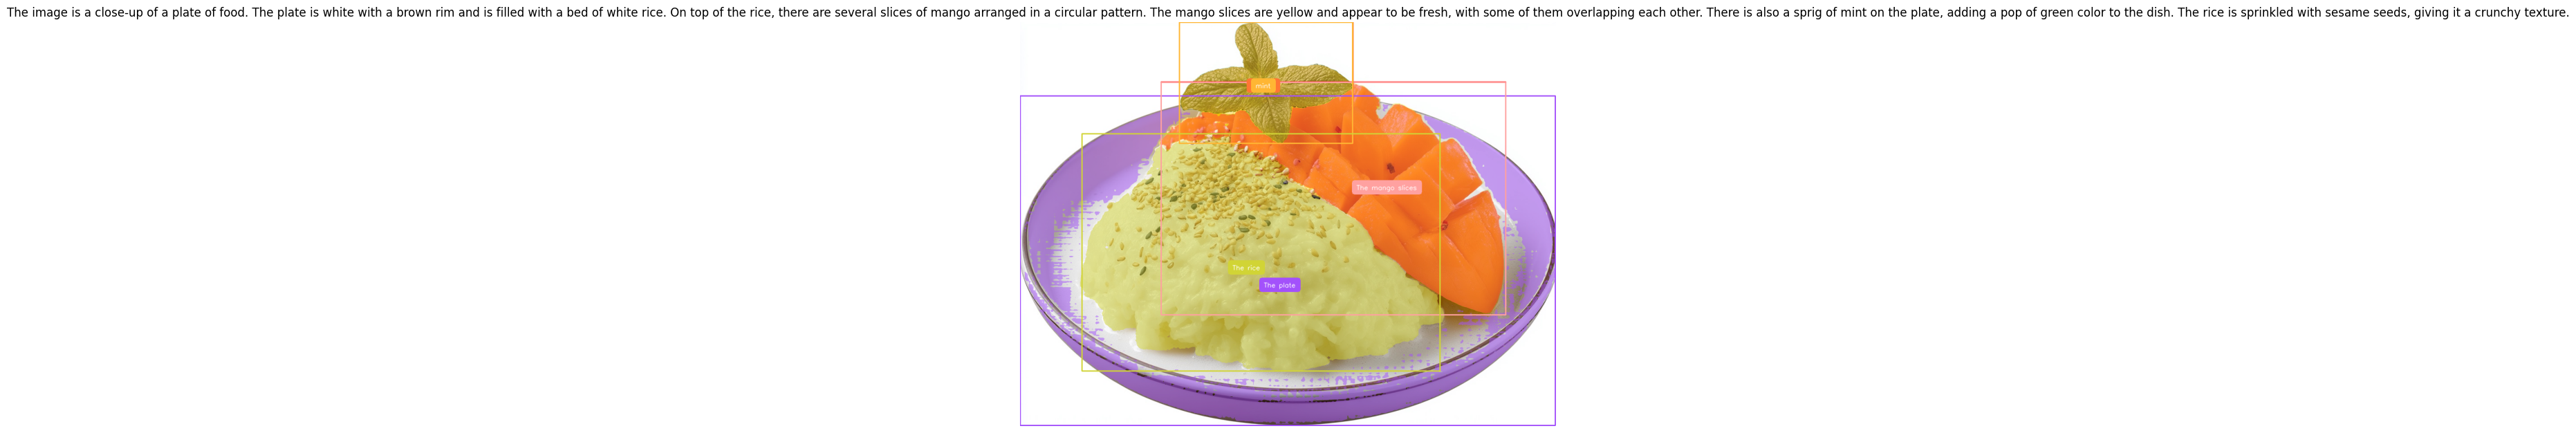

In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import IMAGE_OPEN_VOCABULARY_DETECTION_MODE, IMAGE_CAPTION_GROUNDING_MASKS_MODE
from utils.sam import load_sam_image_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_image_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == IMAGE_OPEN_VOCABULARY_DETECTION_MODE:
        if not text_input:
            return None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), None

    elif mode == IMAGE_CAPTION_GROUNDING_MASKS_MODE:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), caption

# Display the image
def display_image(image, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    if caption:
        plt.title(caption)
    plt.show()

# Examples for testing
EXAMPLES = [
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "/content/florence-sam/mango.jpeg", None],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", None],
]

# Main processing
mode = EXAMPLES[3][0]
image_path = EXAMPLES[3][1]
text_input = EXAMPLES[3][2]

annotated_image, caption = process_image(mode, image_path, text_input)
display_image(annotated_image, caption)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Processing mode: open vocabulary detection + image masks
Image path: /content/florence-sam/mango.jpeg
Text input: mango


SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


Found 1 detections
----------------------------------------


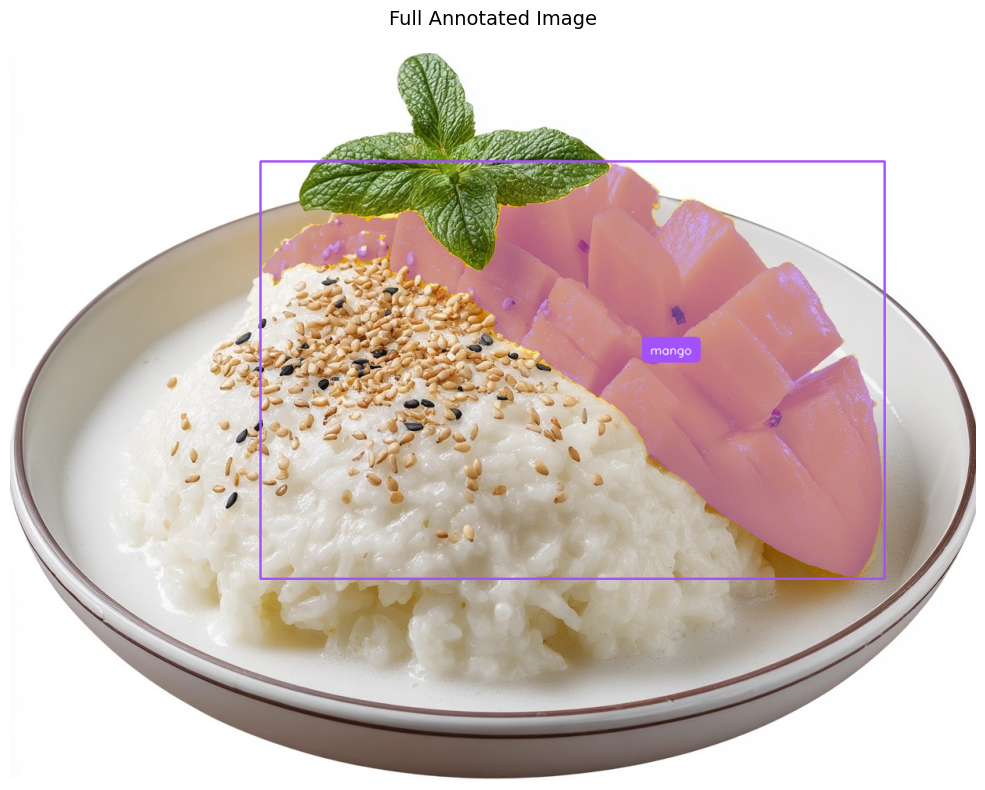

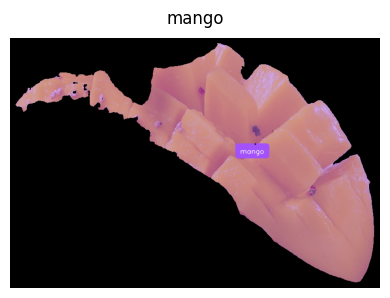


DETECTION SUMMARY:
----------------------------------------
 1. mango
    Bounding box: (319.7, 139.7) to (1115.6, 671.4)



In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import IMAGE_OPEN_VOCABULARY_DETECTION_MODE, IMAGE_CAPTION_GROUNDING_MASKS_MODE
from utils.sam import load_sam_image_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_image_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[sv.Detections], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == IMAGE_OPEN_VOCABULARY_DETECTION_MODE:
        if not text_input:
            return None, None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, None

    elif mode == IMAGE_CAPTION_GROUNDING_MASKS_MODE:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, caption

# Display the image and subplots for each detection with improved readability
def display_image_with_subplots(image, detections, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)

    num_detections = len(detections.xyxy) if detections else 0

    # Print the caption first for better readability
    if caption:
        print("=" * 80)
        print("CAPTION:")
        print(caption)
        print("=" * 80)

    # Handle case where there are no detections
    if num_detections == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)
        ax.axis('off')
        ax.set_title("Full Image (No detections found)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        return

    print(f"Found {num_detections} detections")
    print("-" * 40)

    # Display full annotated image first
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')
    title = "Full Annotated Image"
    if caption:
        # Truncate long captions for title
        short_caption = caption[:60] + "..." if len(caption) > 60 else caption
        title = f"Full Image: {short_caption}"
    ax.set_title(title, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Calculate optimal grid layout for detections
    if num_detections <= 3:
        cols = num_detections
        rows = 1
    elif num_detections <= 6:
        cols = 3
        rows = 2
    elif num_detections <= 9:
        cols = 3
        rows = 3
    else:
        cols = 4
        rows = (num_detections + 3) // 4

    # Display individual detections in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    # Handle single row/column cases
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    # Plot each detection separately with labels
    detection_labels = getattr(detections, 'data', {}).get('class_name', [f"Detection {i+1}" for i in range(num_detections)])

    if detections and hasattr(detections, 'mask') and detections.mask is not None:
        for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
            if i >= len(axes):
                break

            # Create masked image
            masked_image = image.copy()
            masked_image[~mask] = 0

            # Crop to bounding box with some padding
            x1, y1, x2, y2 = box.astype(int)
            padding = 10
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(image.shape[1], x2 + padding)
            y2 = min(image.shape[0], y2 + padding)

            cropped_image = masked_image[y1:y2, x1:x2]

            axes[i].imshow(cropped_image)
            axes[i].axis('off')

            # Add detection label
            if i < len(detection_labels):
                label = detection_labels[i]
            else:
                label = f"Detection {i+1}"

            axes[i].set_title(f"{label}", fontsize=12, pad=10)

    # Hide unused subplots
    for i in range(num_detections, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection summary
    print("\nDETECTION SUMMARY:")
    print("-" * 40)
    for i in range(num_detections):
        box = detections.xyxy[i]
        label = detection_labels[i] if i < len(detection_labels) else f"Detection {i+1}"
        print(f"{i+1:2d}. {label}")
        print(f"    Bounding box: ({box[0]:.1f}, {box[1]:.1f}) to ({box[2]:.1f}, {box[3]:.1f})")
        if hasattr(detections, 'confidence') and detections.confidence is not None:
            print(f"    Confidence: {detections.confidence[i]:.3f}")
        print()

# Examples for testing
EXAMPLES = [
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "/content/florence-sam/mango.jpeg", 'mango'],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", None],
]

# Main processing
# mode = EXAMPLES[3][0]
mode = IMAGE_OPEN_VOCABULARY_DETECTION_MODE
image_path = EXAMPLES[3][1]
text_input = EXAMPLES[3][2]

annotated_image, detections, caption = process_image(mode, image_path, text_input)
display_image_with_subplots(annotated_image, detections, caption)

Processing mode: caption + grounding + image masks
Image path: /content/florence-sam/mango.jpeg
Text input: None
CAPTION:
The image is a close-up of a plate of food. The plate is white with a brown rim and is filled with a bed of white rice. On top of the rice, there are several slices of mango arranged in a circular pattern. The mango slices are yellow and appear to be fresh, with some of them overlapping each other. There is also a sprig of mint on the plate, adding a pop of green color to the dish. The rice is sprinkled with sesame seeds, giving it a crunchy texture.
Found 6 detections
----------------------------------------


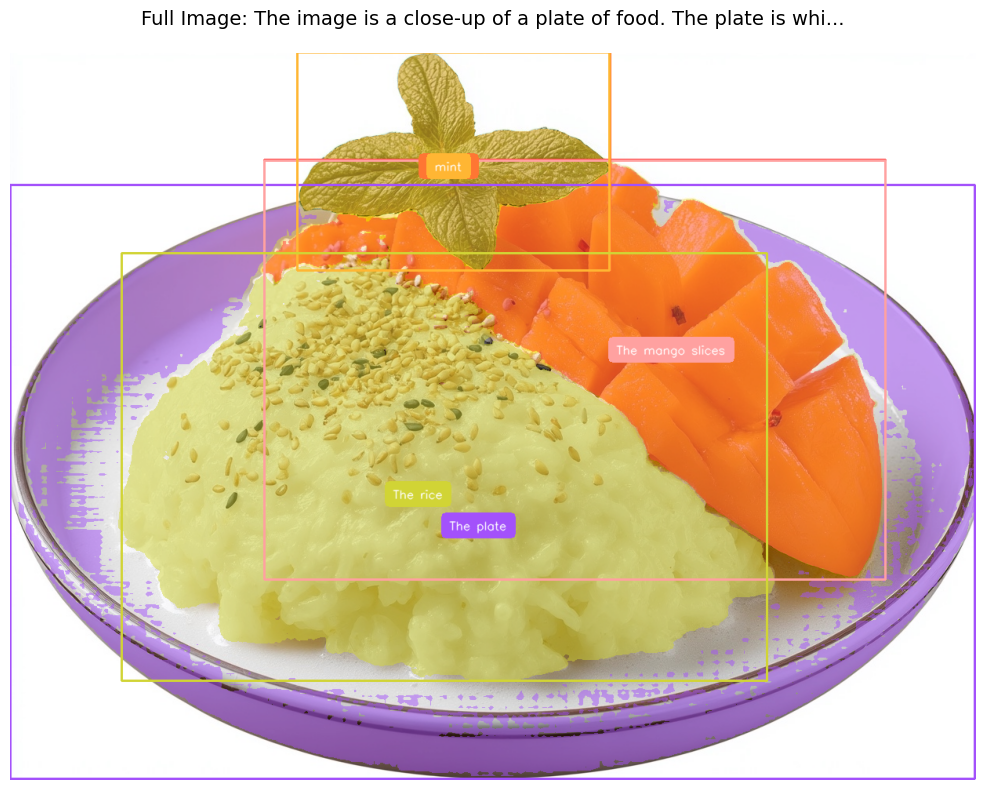

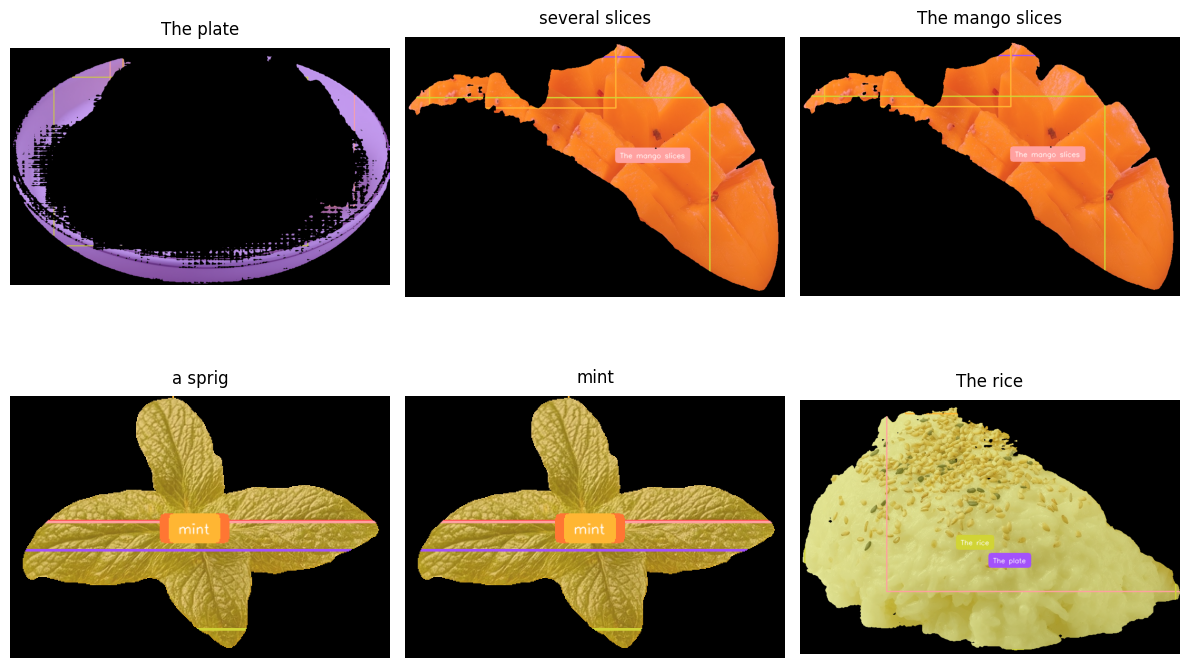


DETECTION SUMMARY:
----------------------------------------
 1. The plate
    Bounding box: (0.6, 169.4) to (1230.2, 926.6)

 2. several slices
    Bounding box: (324.6, 137.8) to (1116.8, 672.3)

 3. The mango slices
    Bounding box: (324.6, 138.7) to (1116.8, 672.3)

 4. a sprig
    Bounding box: (366.5, 0.5) to (765.7, 278.9)

 5. mint
    Bounding box: (366.5, 0.5) to (764.5, 278.9)

 6. The rice
    Bounding box: (142.3, 256.6) to (965.3, 801.3)



In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import IMAGE_OPEN_VOCABULARY_DETECTION_MODE, IMAGE_CAPTION_GROUNDING_MASKS_MODE
from utils.sam import load_sam_image_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_image_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[sv.Detections], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == IMAGE_OPEN_VOCABULARY_DETECTION_MODE:
        if not text_input:
            return None, None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, None

    elif mode == IMAGE_CAPTION_GROUNDING_MASKS_MODE:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, caption

# Display the image and subplots for each detection with improved readability
def display_image_with_subplots(image, detections, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)

    num_detections = len(detections.xyxy) if detections else 0

    # Print the caption first for better readability
    if caption:
        print("=" * 80)
        print("CAPTION:")
        print(caption)
        print("=" * 80)

    # Handle case where there are no detections
    if num_detections == 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)
        ax.axis('off')
        ax.set_title("Full Image (No detections found)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        return

    print(f"Found {num_detections} detections")
    print("-" * 40)

    # Display full annotated image first
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')
    title = "Full Annotated Image"
    if caption:
        # Truncate long captions for title
        short_caption = caption[:60] + "..." if len(caption) > 60 else caption
        title = f"Full Image: {short_caption}"
    ax.set_title(title, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Calculate optimal grid layout for detections
    if num_detections <= 3:
        cols = num_detections
        rows = 1
    elif num_detections <= 6:
        cols = 3
        rows = 2
    elif num_detections <= 9:
        cols = 3
        rows = 3
    else:
        cols = 4
        rows = (num_detections + 3) // 4

    # Display individual detections in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    # Handle single row/column cases
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    # Plot each detection separately with labels
    detection_labels = getattr(detections, 'data', {}).get('class_name', [f"Detection {i+1}" for i in range(num_detections)])

    if detections and hasattr(detections, 'mask') and detections.mask is not None:
        for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
            if i >= len(axes):
                break

            # Create masked image
            masked_image = image.copy()
            masked_image[~mask] = 0

            # Crop to bounding box with some padding
            x1, y1, x2, y2 = box.astype(int)
            padding = 10
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(image.shape[1], x2 + padding)
            y2 = min(image.shape[0], y2 + padding)

            cropped_image = masked_image[y1:y2, x1:x2]

            axes[i].imshow(cropped_image)
            axes[i].axis('off')

            # Add detection label
            if i < len(detection_labels):
                label = detection_labels[i]
            else:
                label = f"Detection {i+1}"

            axes[i].set_title(f"{label}", fontsize=12, pad=10)

    # Hide unused subplots
    for i in range(num_detections, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection summary
    print("\nDETECTION SUMMARY:")
    print("-" * 40)
    for i in range(num_detections):
        box = detections.xyxy[i]
        label = detection_labels[i] if i < len(detection_labels) else f"Detection {i+1}"
        print(f"{i+1:2d}. {label}")
        print(f"    Bounding box: ({box[0]:.1f}, {box[1]:.1f}) to ({box[2]:.1f}, {box[3]:.1f})")
        if hasattr(detections, 'confidence') and detections.confidence is not None:
            print(f"    Confidence: {detections.confidence[i]:.3f}")
        print()

# Examples for testing
EXAMPLES = [
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [IMAGE_OPEN_VOCABULARY_DETECTION_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "/content/florence-sam/mango.jpeg", None],
    [IMAGE_CAPTION_GROUNDING_MASKS_MODE, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", None],
]

# Main processing
mode = EXAMPLES[3][0]
image_path = EXAMPLES[3][1]
text_input = EXAMPLES[3][2]

annotated_image, detections, caption = process_image(mode, image_path, text_input)
display_image_with_subplots(annotated_image, detections, caption)

Processing mode: caption + grounding + masks
Image path: /content/florence-sam/t_damaged.png
Text input: None


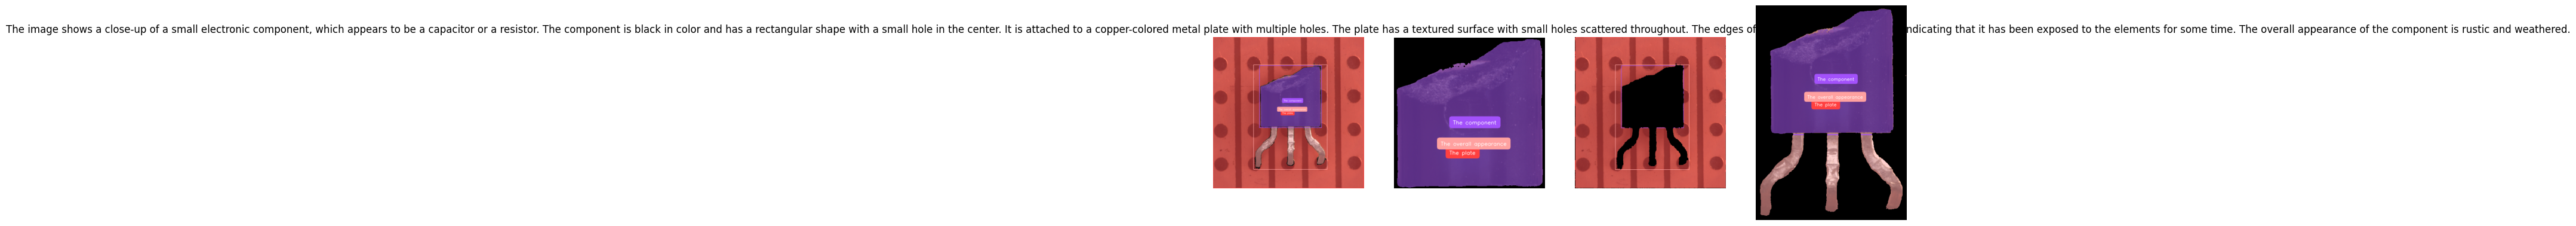

In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import INFERENCE_MODES, OPEN_VOCABULARY_DETECTION, CAPTION_GROUNDING_MASKS
from utils.sam import load_sam_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[sv.Detections], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == OPEN_VOCABULARY_DETECTION:
        if not text_input:
            return None, None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, None

    elif mode == CAPTION_GROUNDING_MASKS:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, caption

# Display the image and subplots for each detection
def display_image_with_subplots(image, detections, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)

    num_detections = len(detections.xyxy) if detections else 0
    fig, axes = plt.subplots(1, num_detections + 1, figsize=(15, 10))

    # Plot the full annotated image
    axes[0].imshow(image)
    axes[0].axis('off')
    if caption:
        axes[0].set_title(caption)

    # Plot each detection separately
    for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
        masked_image = image.copy()
        masked_image[~mask] = 0
        x1, y1, x2, y2 = box
        cropped_image = masked_image[int(y1):int(y2), int(x1):int(x2)]
        axes[i + 1].imshow(cropped_image)
        axes[i + 1].axis('off')

    plt.show()

# Examples for testing
EXAMPLES = [
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_good.png", None],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_damaged.png", None],
]

# Main processing
mode = EXAMPLES[4][0]
image_path = EXAMPLES[4][1]
text_input = EXAMPLES[4][2]

annotated_image, detections, caption = process_image(mode, image_path, text_input)
display_image_with_subplots(annotated_image, detections, caption)


Processing mode: caption + grounding + masks
Image path: /content/florence-sam/t_missplace.png
Text input: None


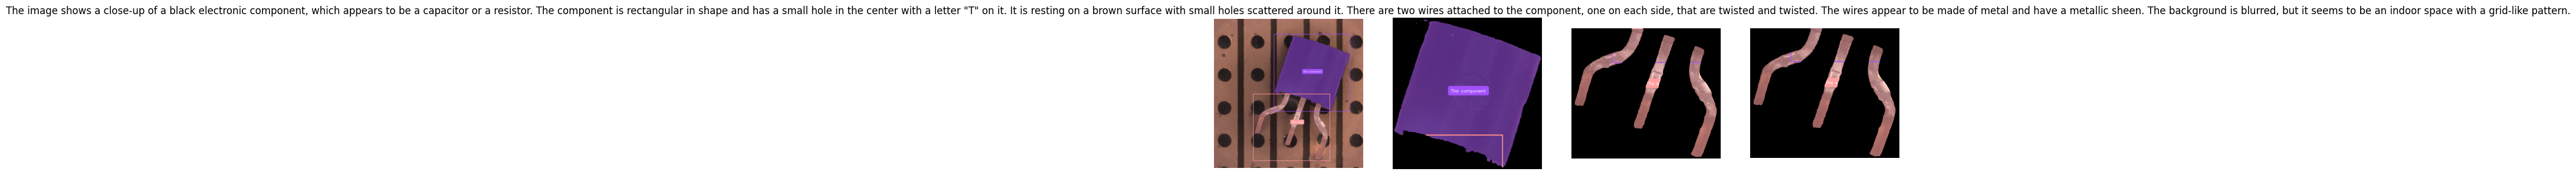

In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import INFERENCE_MODES, OPEN_VOCABULARY_DETECTION, CAPTION_GROUNDING_MASKS
from utils.sam import load_sam_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[sv.Detections], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == OPEN_VOCABULARY_DETECTION:
        if not text_input:
            return None, None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, None

    elif mode == CAPTION_GROUNDING_MASKS:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, caption

# Display the image and subplots for each detection
def display_image_with_subplots(image, detections, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)

    num_detections = len(detections.xyxy) if detections else 0
    fig, axes = plt.subplots(1, num_detections + 1, figsize=(15, 10))

    # Plot the full annotated image
    axes[0].imshow(image)
    axes[0].axis('off')
    if caption:
        axes[0].set_title(caption)

    # Plot each detection separately
    for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
        masked_image = image.copy()
        masked_image[~mask] = 0
        x1, y1, x2, y2 = box
        cropped_image = masked_image[int(y1):int(y2), int(x1):int(x2)]
        axes[i + 1].imshow(cropped_image)
        axes[i + 1].axis('off')

    plt.show()

# Examples for testing
EXAMPLES = [
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_good.png", None],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_damaged.png", None],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_missplace.png", None],
]

# Main processing
mode = EXAMPLES[5][0]
image_path = EXAMPLES[5][1]
text_input = EXAMPLES[5][2]

annotated_image, detections, caption = process_image(mode, image_path, text_input)
display_image_with_subplots(annotated_image, detections, caption)


Processing mode: caption + grounding + masks
Image path: /content/florence-sam/t_good.png
Text input: None


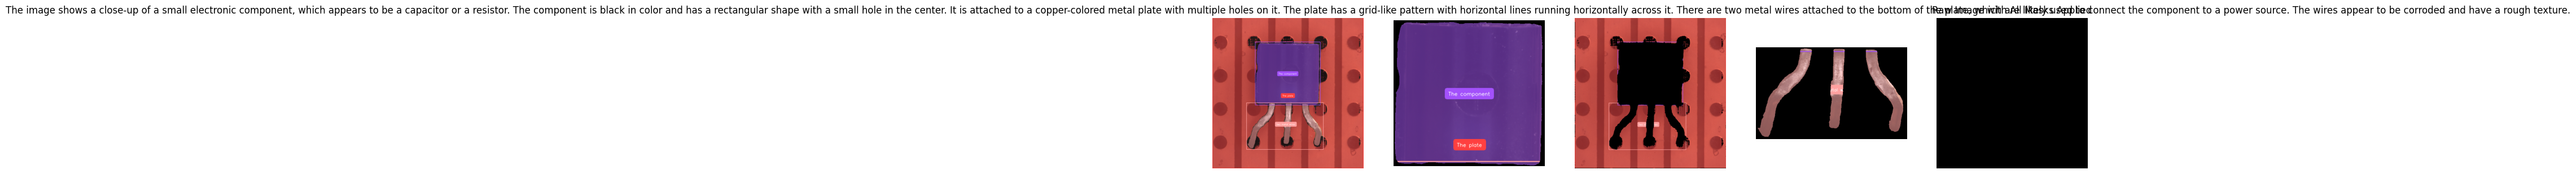

In [ ]:
from typing import Tuple, Optional
import requests
from io import BytesIO

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import supervision as sv
from utils.florence import load_florence_model, run_florence_inference, FLORENCE_DETAILED_CAPTION_TASK, FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import INFERENCE_MODES, OPEN_VOCABULARY_DETECTION, CAPTION_GROUNDING_MASKS
from utils.sam import load_sam_model, run_sam_inference

# Load models and annotators
DEVICE = torch.device("cuda")
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_MODEL = load_sam_model(device=DEVICE)
BOX_ANNOTATOR = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#FFFFFF"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Load image from a URL or local path
def load_image(image_path: str) -> Image.Image:
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image

# Annotate image with detections
def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image

# Process image based on the selected mode and input text
def process_image(mode: str, image_path: str, text_input: Optional[str] = None) -> Tuple[Optional[Image.Image], Optional[sv.Detections], Optional[str]]:
    print(f"Processing mode: {mode}")
    print(f"Image path: {image_path}")
    print(f"Text input: {text_input}")

    image = load_image(image_path)
    if mode == OPEN_VOCABULARY_DETECTION:
        if not text_input:
            return None, None, None
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
            text=text_input
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, None

    elif mode == CAPTION_GROUNDING_MASKS:
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_DETAILED_CAPTION_TASK
        )
        caption = result[FLORENCE_DETAILED_CAPTION_TASK]
        _, result = run_florence_inference(
            model=FLORENCE_MODEL,
            processor=FLORENCE_PROCESSOR,
            device=DEVICE,
            image=image,
            task=FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK,
            text=caption
        )
        detections = sv.Detections.from_lmm(
            lmm=sv.LMM.FLORENCE_2,
            result=result,
            resolution_wh=image.size
        )
        detections = run_sam_inference(SAM_MODEL, image, detections)
        return annotate_image(image, detections), detections, caption

# Display the image and subplots for each detection
def display_image_with_subplots(image, detections, caption=None):
    if image is None:
        print("No image to display.")
        return
    if isinstance(image, Image.Image):
        image = np.array(image)

    num_detections = len(detections.xyxy) if detections else 0
    fig, axes = plt.subplots(1, num_detections + 2, figsize=(20, 10))

    # Plot the full annotated image
    axes[0].imshow(image)
    axes[0].axis('off')
    if caption:
        axes[0].set_title(caption)

    # Plot each detection separately
    for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
        masked_image = image.copy()
        masked_image[~mask] = 0
        x1, y1, x2, y2 = box
        cropped_image = masked_image[int(y1):int(y2), int(x1):int(x2)]
        axes[i + 1].imshow(cropped_image)
        axes[i + 1].axis('off')

    # Plot the raw image with all masks applied
    all_masks_applied = image.copy()
    for mask in detections.mask:
        all_masks_applied[~mask] = 0
    axes[-1].imshow(all_masks_applied)
    axes[-1].axis('off')
    axes[-1].set_title("Raw Image with All Masks Applied")

    plt.show()

# Examples for testing
EXAMPLES = [
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'straw'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-2.jpeg", 'napkin'],
    [OPEN_VOCABULARY_DETECTION, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", 'tail'],
    [CAPTION_GROUNDING_MASKS, "/content/florence-sam/t_good.png", None],
    [CAPTION_GROUNDING_MASKS, "https://media.roboflow.com/notebooks/examples/dog-3.jpeg", None],
]

# Main processing
mode = EXAMPLES[3][0]
image_path = EXAMPLES[3][1]
text_input = EXAMPLES[3][2]

annotated_image, detections, caption = process_image(mode, image_path, text_input)
display_image_with_subplots(annotated_image, detections, caption)
